@Author: Fantasy_Silence            
@Time: 2024-04-24                   
@IDE: Visual Studio Code & PyCharm  
@Python: 3.9.7                      
@Description: Using my data         

# 一、导入必要的模块

In [1]:
print("=" * 50)
print("1.导入必要的模块")
print("=" * 50)
import time
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

from src.common.fileTool.filesio import FilesIO
from src.common.infoTool.const import CONST_TABLE
from src.common.modelTool.split import TargetVaribleSplit
from src.modules.datapreparation.dataparser import HousingDataParser
from src.modules.datapreparation.datacrawler import HousingDataSpider
from src.modules.visualization.geo_distribute import DrawGeoDistribution
from src.modules.datapreparation.pipeline58 import PipeLineFor58HousingData
from src.common.infoTool.randomIPandHeaders import RandomRequestInfoGenerator
print(
    "完成'导入必要的模块'", end="\n\n"
)

1.导入必要的模块
完成'导入必要的模块'



# 二、数据爬取与解析

In [ ]:
print("=" * 50)
print("2.数据爬取与解析")
print("=" * 50)
start_time = time.time()
for city in CONST_TABLE["CITY"].keys():
    proxies, headers = RandomRequestInfoGenerator.get()
    HousingDataSpider(city=city, headers=headers, proxies=proxies)
    HousingDataParser(city=city)
end_time = time.time()
print(
    "完成'数据爬取与解析', 用时%.3fms" % 
    ((end_time - start_time) * 1000), end="\n\n"
)

# 三、以成都的房价数据为例进行

## 0.数据可视化

In [2]:
row_data = pd.read_csv(FilesIO.getDataset("row_data/CD_housing_data.csv"))
row_data.head()

,ID,houseLoc,longitude,latitude,unitPrice,housePrice,houseArea,houseBedroom,houseLivingRoom,houseBathroom,...,houseAge,houseSubway,houseHousingPeriod,houseFloorType,houseFloorSum,busAround,schoolAround,parkAround,shopping_mallAround,subwayAround
0,1,天府新区华阳万东路80号附1号滨江和城,104.081835,30.490836,18584,170.0,91.48,3,2,2,...,6,1,满二年,低层,32,10,3,0,10,2
1,2,"高新区世纪城世纪城路996号,天府大道中段177号天鹅湖北苑",104.068682,30.559357,15935,145.0,91.00,3,2,2,...,6,1,满五年,高层,12,10,10,2,10,2
2,3,天府新区南湖南湖大道333号远大中央公园,104.046828,30.493299,18036,175.0,97.03,3,2,2,...,6,0,NaN,高层,32,10,10,0,10,1
3,4,新都大丰花都大道789号嘉美华凯(一二期),104.057887,30.762774,12030,118.0,98.09,3,2,1,...,12,1,满五年,低层,18,10,10,3,10,2
4,5,新都大丰金源街18号汇融广场B区,104.059093,30.767943,12398,113.2,91.31,3,2,1,...,8,1,满五年,中层,42,10,10,2,10,1


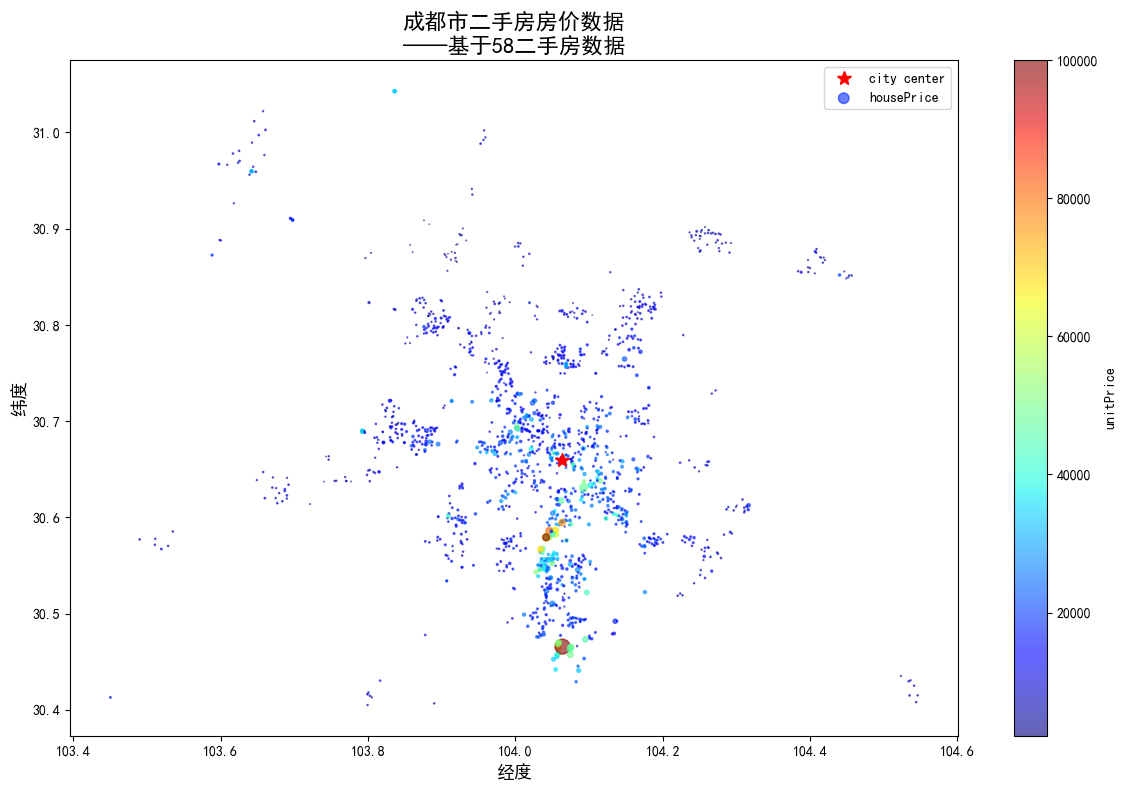

In [4]:
DrawGeoDistribution("CD").draw(is_show_alone=True, is_show=True)

## 1. 数据预处理并划分训练集

In [5]:
print("=" * 50)
print("3.1.数据预处理并划分训练集")
print("=" * 50)
start_time = time.time()
pipe = Pipeline([
    ('prep', PipeLineFor58HousingData(city_name="CD")),
    ('split', TargetVaribleSplit(target="unitPrice")),
])
X_train, X_test, y_train, y_test = train_test_split(
    *pipe.fit_transform(row_data), test_size=0.3, random_state=42
)
end_time = time.time()
print(
    "完成'数据预处理并划分训练集', 用时%.3fms" % 
    ((end_time - start_time) * 1000), end="\n\n"
)

3.1.数据预处理并划分训练集
完成'数据预处理并划分训练集', 用时480.538ms



## 2.寻找最佳的模型

3.2.寻找最佳的模型
Tree: -0.207122 (0.042945)
SVM: -0.141921 (0.034059)
LR: -0.154678 (0.035148)
ElasticNet: -0.307305 (0.045985)
SGD: -0.376451 (0.109495)
RF: -0.116096 (0.024039)
GB: -0.121384 (0.023532)
Ada: -0.131219 (0.028692)


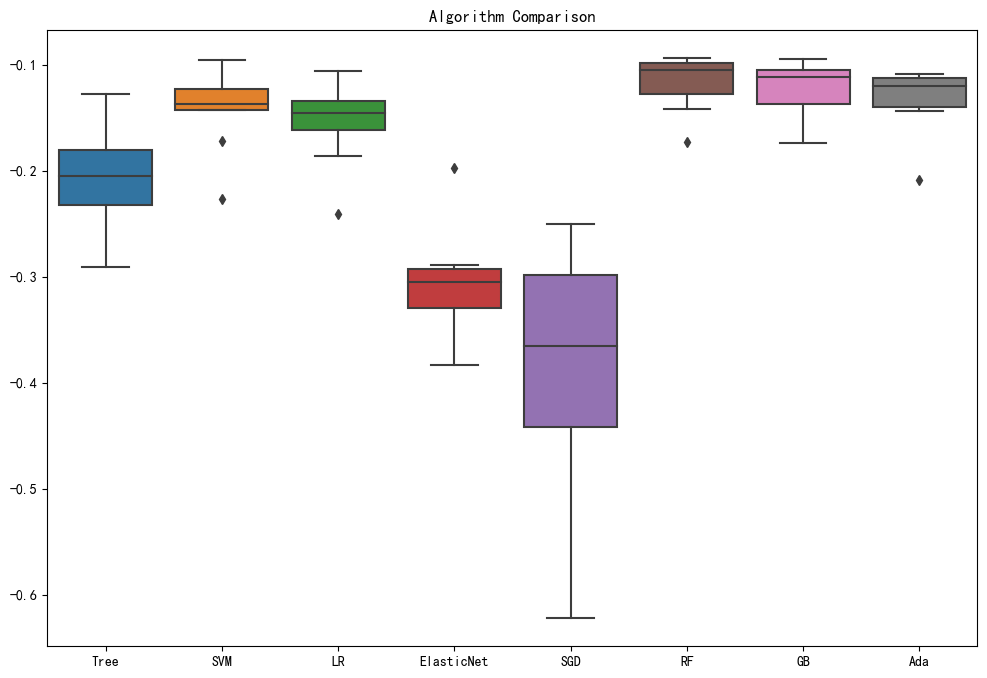

完成'寻找最佳的模型', 用时22357.850ms



In [6]:
print("=" * 50)
print("3.2.寻找最佳的模型")
print("=" * 50)
models = []
models.append(("Tree", DecisionTreeRegressor()))
models.append(("SVM", SVR()))
# 线性模型
models.append(("LR", LinearRegression()))
models.append(("ElasticNet", ElasticNet()))
models.append(("SGD", SGDRegressor()))
# Bagging
models.append(("RF", RandomForestRegressor()))
# Boost
models.append(("GB", GradientBoostingRegressor()))
models.append(("Ada", AdaBoostRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.boxplot(results, ax=ax)
ax.set_title('Algorithm Comparison')
ax.set_xticklabels(names)
plt.show()
end_time = time.time()
print(
    "完成'寻找最佳的模型', 用时%.3fms" % 
    ((end_time - start_time) * 1000), end="\n\n"
)

## 3.对最佳选择进行网格搜索

In [4]:
print("=" * 50)
print("3.3.对最佳选择进行网格搜索")
print("=" * 50)
param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_features": [0.2, 0.4, 0.6, 0.8, 1],
    "max_samples": [0.2, 0.4, 0.6, 0.8, 1],
    "criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
}
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid, cv=kfold, n_jobs=-1,
)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
end_time = time.time()
print(
    "完成'对最佳选择进行网格搜索', 用时%.3fms" % 
    ((end_time - start_time) * 1000), end="\n\n"
)

3.3.对最佳选择进行网格搜索
{'criterion': 'squared_error', 'max_features': 0.4, 'max_samples': 0.8, 'n_estimators': 400}
完成'对最佳选择进行网格搜索', 用时2383056.714ms



In [7]:
best_regressor = RandomForestRegressor(
    n_estimators=400, max_features=0.4, max_samples=0.8, criterion="squared_error"
)
best_regressor.fit(X_train, y_train)
y_pred = best_regressor.predict(X_test)

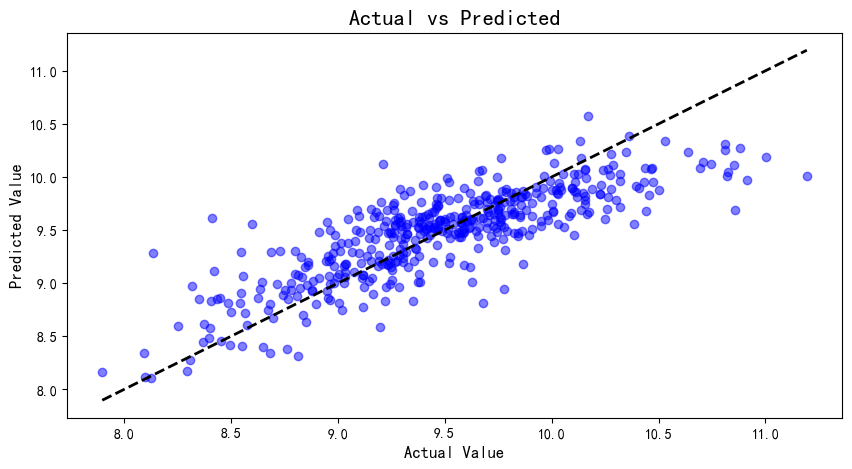

In [8]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.scatter(y_test, y_pred, c="b", alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
ax.set_title("Actual vs Predicted", fontsize=16)
ax.set_ylabel("Predicted Value", fontsize=12)
ax.set_xlabel("Actual Value", fontsize=12)
plt.show()